In [107]:
%load_ext lab_black

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import re
import math
import tensorflow as tf
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from textblob import Word
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor,
    ExtraTreesRegressor,
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
    HashingVectorizer,
)
from lightgbm import LGBMRegressor
import scipy
from xgboost import XGBRegressor
from pprint import pprint
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from joblib import Parallel, delayed
from tune_sklearn import TuneGridSearchCV
import warnings

PANDAS_DEFAULT_MAX_ROWS_OPTIONS = pd.get_option("display.max_rows")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [151]:
traintest.loc[traintest.Route.isnull(), "Route"] = "DEL COK"  # fix data
traintest["Route"] = traintest["Route"].str.replace("[^\w ]", "")

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [159]:
traintest[traintest.Route == "DEL  BOM  COK"].mean()

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


index                              4448.421333
Total_Stops                           1.000000
Price                             10954.205808
istrain                               0.792000
total_duration                      735.758333
is_premium_economy                    0.005333
is_business                           0.000000
month                                 4.900000
day                                  14.018000
weekday                               2.767333
is_weekend                            0.298333
overnight_arrival                     0.447667
meal_not_included                     0.254000
baggage_not_included                  0.000000
departer_hour                        11.756667
arrival_hour                         13.277000
is_arrival_early_morning              0.297333
is_arrival_late_evening               0.558000
is_arrival_daytime                    0.144667
is_early_morning                      0.118667
is_late_evening                       0.185333
is_daytime   

In [167]:
train = pd.read_excel("Data_Train.xlsx")
test = pd.read_excel("Test_set.xlsx")
train["istrain"] = 1
test["istrain"] = 0
traintest = pd.concat([train, test], axis=0).reset_index()
traintest.loc[traintest.Route.isnull(), "Route"] = "DEL COK"  # fix data
traintest["Route"] = traintest["Route"].str.replace("[^\w ]", "")
traintest["Duration"] = pd.to_timedelta(traintest["Duration"])
traintest["total_duration"] = (traintest.Duration.dt.total_seconds() / 60).astype(float)
traintest.loc[
    traintest.Destination == "New Delhi", "Destination"
] = "Delhi"  # delhi and new delhi are the same, rename the destination for consistency
traintest["Total_Stops"] = (
    traintest.Total_Stops.str.extract("(\d+)").fillna(0).astype(int)
)
traintest["leg"] = traintest["Source"] + " " + traintest["Destination"]
traintest["is_premium_economy"] = traintest.Airline.str.contains("Premium").astype(int)
traintest["is_business"] = traintest.Airline.str.contains("Business").astype(int)
traintest.loc[traintest.Additional_Info.str.contains("Business"), "is_business"] = 1
traintest["Date_of_Journey"] = pd.to_datetime(
    traintest.Date_of_Journey, format="%d/%m/%Y"
)
traintest["month"] = traintest.Date_of_Journey.dt.month
traintest["day"] = traintest.Date_of_Journey.dt.day
traintest["weekday"] = traintest.Date_of_Journey.dt.weekday
traintest["is_weekend"] = (traintest.Date_of_Journey.dt.weekday > 4).astype(int)
traintest["overnight_arrival"] = traintest.Arrival_Time.str.len() > 5
traintest["overnight_arrival"] = traintest["overnight_arrival"].astype(int)
traintest["air"] = traintest.Airline
traintest["air"] = traintest.air.str.replace(" Premium economy", "")
traintest["air"] = traintest.air.str.replace(" Business", "")
traintest["meal_not_included"] = traintest.Additional_Info.str.contains(
    "meal not included"
).astype(int)
traintest["baggage_not_included"] = traintest.Additional_Info.str.contains(
    "baggage included"
).astype(int)
traintest["departer_hour"] = traintest.Dep_Time.apply(lambda x: int(x.split(":")[0]))
traintest["arrival_hour"] = traintest.Arrival_Time.str.extract("(\d+):").astype(int)
traintest["is_arrival_early_morning"] = (traintest.arrival_hour < 7).astype(int)
traintest["is_arrival_late_evening"] = (traintest.arrival_hour >= 18).astype(int)
traintest.loc[
    (traintest.arrival_hour >= 7) & (traintest.arrival_hour < 18), "is_arrival_daytime"
] = 1
assert len(traintest[traintest.istrain == 0]) == len(test)
traintest["is_arrival_daytime"] = traintest["is_arrival_daytime"].fillna(0)
traintest["is_arrival_daytime"] = traintest["is_arrival_daytime"].astype(int)
traintest["transit1"] = traintest.Route.apply(
    lambda x: x.split()[1] if len(x.split()) > 2 else np.nan
).fillna("INVALID")
traintest["transit2"] = traintest.Route.apply(
    lambda x: x.split()[2] if len(x.split()) > 3 else np.nan
).fillna("INVALID")
traintest["transit3"] = traintest.Route.apply(
    lambda x: x.split()[3] if len(x.split()) > 4 else np.nan
).fillna("INVALID")
traintest["is_early_morning"] = (traintest.departer_hour < 7).astype(int)
traintest["is_late_evening"] = (traintest.departer_hour >= 18).astype(int)
traintest.loc[
    (traintest.departer_hour >= 7) & (traintest.departer_hour < 18), "is_daytime"
] = 1
traintest["is_daytime"] = traintest["is_daytime"].fillna(0)
traintest["is_daytime"] = traintest["is_daytime"].astype(int)
# traintest.drop(
#     traintest[(traintest.Price > 26890.0) & (traintest.istrain == 1)].index,
#     inplace=True,
# )  # drop weird prices
traintest.loc[(traintest.Duration < "1h") & (traintest.istrain == 1), "Duration"] = "1d"
traintest["transits"] = traintest.Route.apply(lambda x: " ".join(x.split()[1:-1]))
traintest["Source"] = traintest.Route.apply(lambda x: x.split()[0])
traintest["air_map"] = traintest.air.map(traintest.air.value_counts())

traintest["Destination"] = traintest.Route.apply(lambda x: x.split()[-1])
traintest["source_map"] = traintest.Source.map(traintest.Source.value_counts())
traintest["dest_map"] = traintest.Destination.map(traintest.Destination.value_counts())
# traintest["transit1"] = traintest.transit1.map(traintest.transit1.value_counts())
# traintest["transit2"] = traintest.transit2.map(traintest.transit2.value_counts())
# traintest["transit3"] = traintest.transit3.map(traintest.transit3.value_counts())
all_transits = " ".join(
    traintest.Route.apply(lambda x: " ".join(x.split()[1:-1]))
).split()
transits = {k: all_transits.count(k) for k in set(all_transits)}
traintest["source_popularity"] = traintest.Source.apply(lambda x: transits[x])
traintest["destination_popularity"] = traintest.Destination.apply(lambda x: transits[x])
traintest["transit_airport_min_popularity"] = traintest.transits.apply(
    lambda x: min(map(lambda y: transits[y], x.split())) if x else 9999
)
traintest["transit_airport_max_popularity"] = traintest.transits.apply(
    lambda x: min(map(lambda y: transits[y], x.split())) if x else 0
)
traintest["route_mean_popularity"] = traintest.Route.apply(
    lambda x: np.mean([transits[i] for i in x.split()])
)
traintest["route_min_popularity"] = traintest.Route.apply(
    lambda x: np.min([transits[i] for i in x.split()])
)
traintest["route_max_popularity"] = traintest.Route.apply(
    lambda x: np.max([transits[i] for i in x.split()])
)

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [93]:
traintest.total_duration

,departer_hour_freq,Price
departer_hour_freq,1.000000,0.042959
Price,0.042959,1.000000


In [4]:
traintest.Source.value_counts()

DEL    5682
CCU    3581
BLR    2752
BOM     883
MAA     456
Name: Source, dtype: int64

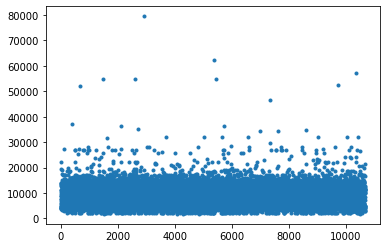

In [6]:
plt.plot(traintest.Price, ".")

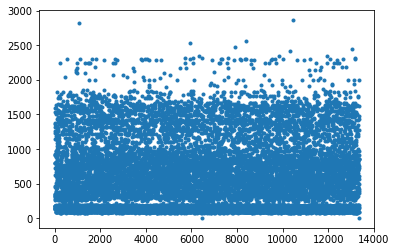

In [7]:
plt.plot(traintest.total_duration, ".")

distribution for weekday is also very similar

seems like the most common source is Delhi and the most common destination is Cochin. Perhaps we can draw the distribution of source to destination

In [8]:
traintest.Additional_Info.value_counts()

No info                         10493
In-flight meal not included      2426
No check-in baggage included      396
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
1 Short layover                     1
Red-eye flight                      1
2 Long layover                      1
Name: Additional_Info, dtype: int64

<AxesSubplot:>

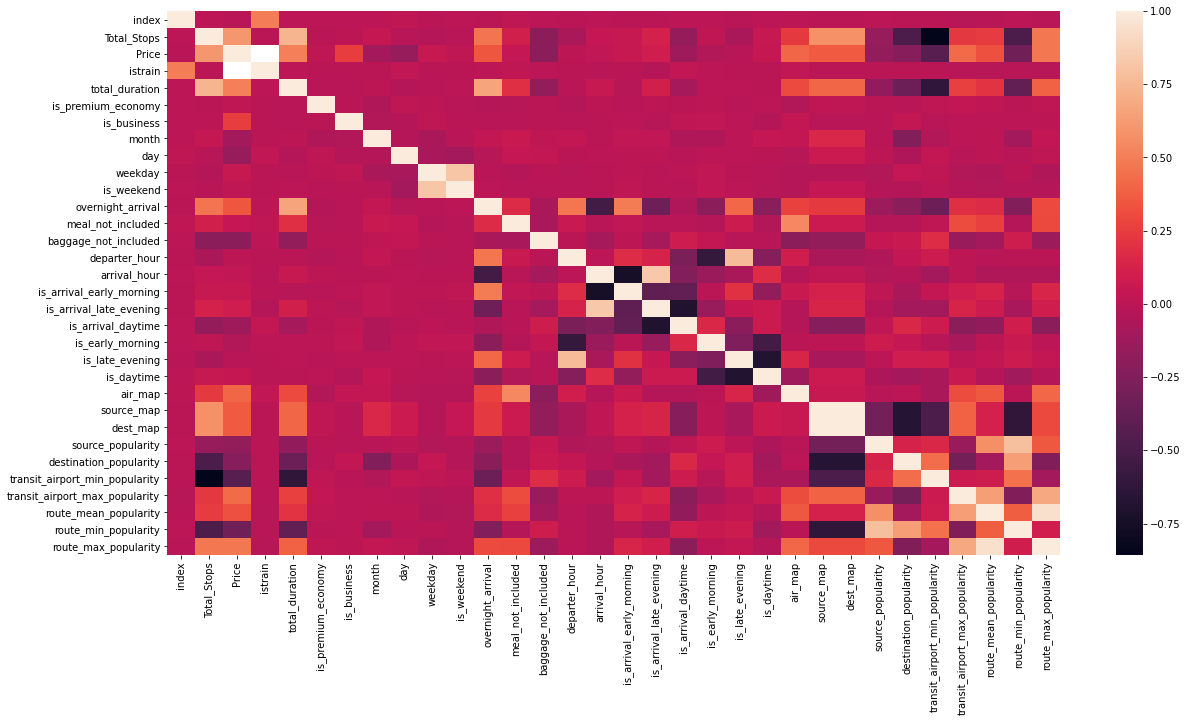

In [168]:
plt.figure(figsize=(20, 10))
sns.heatmap(traintest.corr())

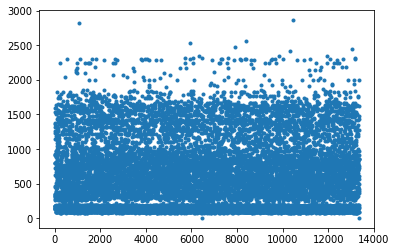

In [10]:
plt.plot(traintest.total_duration, ".")

In [11]:
traintest.total_duration.quantile(0.995)

2240.0

<AxesSubplot:xlabel='total_duration', ylabel='Price'>

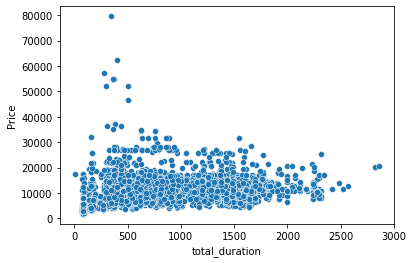

In [12]:
sns.scatterplot(data=traintest, x="total_duration", y="Price")

<AxesSubplot:xlabel='departer_hour', ylabel='Price'>

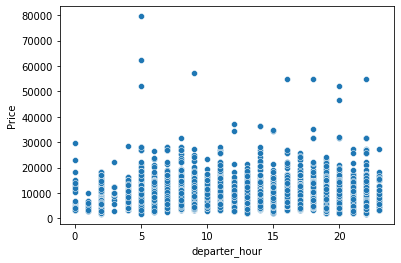

In [13]:
sns.scatterplot(data=traintest, x="departer_hour", y="Price")

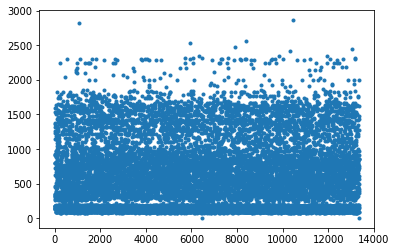

In [14]:
plt.plot(traintest["total_duration"], ".")

<AxesSubplot:>

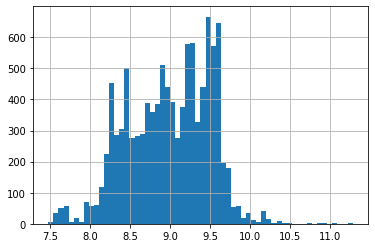

In [15]:
traintest.Price.apply(lambda x: math.log(x)).hist(bins=60)

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


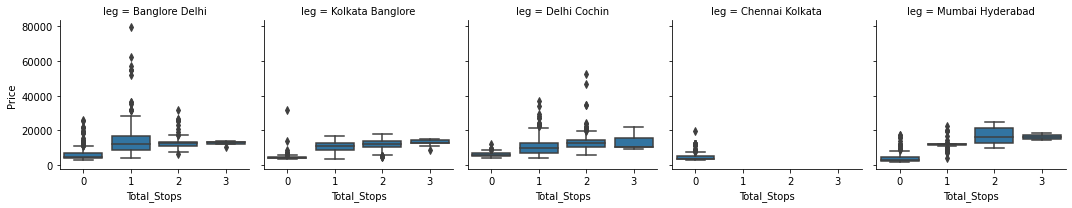

In [16]:
g = sns.FacetGrid(traintest, col="leg")
g.map(sns.boxplot, "Total_Stops", "Price")

In [17]:
traintest.leg.value_counts()

Delhi Cochin        5682
Kolkata Banglore    3581
Banglore Delhi      2752
Mumbai Hyderabad     883
Chennai Kolkata      456
Name: leg, dtype: int64

In [18]:
# fig, axes = plt.subplots(
#     nrows=len(traintest.leg.unique()),
#     ncols=len(traintest.Total_Stops.unique()),
#     figsize=(30, 20),
# )
# for i, leg in enumerate(traintest.leg.unique()):
#     for j, num_stop in enumerate(sorted(traintest.Total_Stops.unique())):
#         upper_quantile = traintest[
#             (traintest.leg == leg) & (traintest.Total_Stops == num_stop)
#         ].Price.quantile(0.995)
#         lower_quantile = traintest[
#             (traintest.leg == leg) & (traintest.Total_Stops == num_stop)
#         ].Price.quantile(0.005)
#         print(
#             f"-- upper quantile for leg {leg} = {upper_quantile}, total stop = {num_stop}"
#         )
#         print(
#             f"-- upper quantile for leg {leg} = {lower_quantile}, total stop = {num_stop}"
#         )
#         axes[i, j].set_xlabel(leg)
#         axes[i, j].set_ylabel(num_stop)
#         axes[i, j].plot(
#             traintest[
#                 (traintest.leg == leg) & (traintest.Total_Stops == num_stop)
#             ].Price,
#             ".",
#         )
#         print("-- dropping outliner prices")
#         traintest.drop(
#             traintest[
#                 (traintest.leg == leg)
#                 & (traintest.Total_Stops == num_stop)
#                 & (
#                     (traintest.Price >= upper_quantile)
#                     | (traintest.Price <= lower_quantile)
#                 )
#             ].index,
#             inplace=True,
#         )

In [19]:
traintest.groupby("Total_Stops").mean().sort_values(by="Price")

,index,Price,istrain,total_duration,is_premium_economy,is_business,month,day,weekday,is_weekend,...,departer_hour,arrival_hour,is_arrival_early_morning,is_arrival_late_evening,is_arrival_daytime,is_early_morning,is_late_evening,is_daytime,transit_airport_min_popularity,transit_airport_max_popularity
Total_Stops,,,,,,,,,,,,,,,,,,,,,
0,4585.753743,5025.603379,0.804423,150.237273,0.001152,0.000230,4.657913,13.744529,3.049297,0.307533,...,12.972126,12.553789,0.167012,0.296475,0.536512,0.185902,0.302926,0.511173,9999.000000,9999.000000
1,4479.255952,10594.123556,0.797194,779.046202,0.002268,0.000850,4.702806,13.060658,2.881803,0.287840,...,12.426871,14.123016,0.171485,0.485686,0.342829,0.134921,0.235828,0.629252,4408.148526,4408.148526
2,4658.481306,12715.807895,0.800421,1232.456556,0.000000,0.001053,4.868352,13.830437,2.887309,0.295419,...,11.922591,12.555556,0.254871,0.410216,0.334913,0.222749,0.215903,0.561348,226.464455,226.464455
3,4522.160714,13112.000000,0.803571,1545.625000,0.000000,0.000000,4.482143,12.875000,3.000000,0.339286,...,8.125000,15.482143,0.089286,0.625000,0.285714,0.482143,0.000000,0.517857,27.946429,27.946429
4,5802.000000,17686.000000,0.500000,1397.500000,0.000000,0.000000,3.000000,1.000000,4.000000,0.000000,...,5.000000,16.500000,0.000000,0.500000,0.500000,1.000000,0.000000,0.000000,39.000000,39.000000


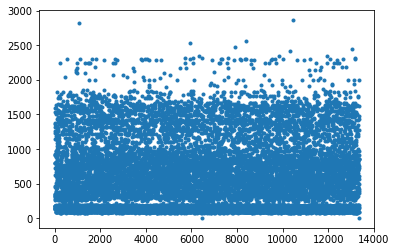

In [20]:
plt.plot(traintest.total_duration, ".")

In [21]:
assert len(traintest[traintest.istrain == 0]) == len(test)

In [22]:
traintest.overnight_arrival.value_counts()

0    7953
1    5401
Name: overnight_arrival, dtype: int64

In [169]:
def proc_text(s):
    dff = []
    for n, c in s.iteritems():
        #         c = CountVectorizer().fit_transform(c)
        c = TfidfVectorizer().fit_transform(c)
        dff.append(pd.DataFrame.sparse.from_spmatrix(c))
    return pd.concat(dff, axis=1)


def metric(y_pred, y_true):
    y_pred = math.e ** y_pred
    y_true = math.e ** y_true
    return 1 - np.sqrt(np.square(np.log10(y_pred + 1) - np.log10(y_true + 1)).mean())


# traintest["Source"] = traintest.Source.map(traintest.Source.value_counts())
# traintest["Destination"] = traintest.Destination.map(
#     traintest.Destination.value_counts()
# )
traintest["source_popularity"] = traintest.Source.apply(lambda x: transits[x])
traintest["destination_popularity"] = traintest.Destination.apply(lambda x: transits[x])
# traintest["transit1"] = traintest.transit1.replace({"INVALID": np.nan})
# traintest["transit2"] = traintest.transit2.replace({"INVALID": np.nan})
# traintest["transit3"] = traintest.transit3.replace({"INVALID": np.nan})
tranformer = ColumnTransformer(
    transformers=[
        (
            "numeric",
            MinMaxScaler(),
            [
                "total_duration",
                "Total_Stops",
                "departer_hour",
                "arrival_hour",
                #                 "transit1",
                #                 "transit2",
                #                 "transit3",
                "transit_airport_min_popularity",
                "transit_airport_max_popularity",
                "source_popularity",
                "destination_popularity",
                "source_map",
                "air_map",
                "dest_map",
                #                 "Source",
                #                 "Destination",
            ],
        ),
        (
            "categorical",
            OneHotEncoder(),
            [
                "air",
                "day",
                "weekday",
                "month",
                "Source",
                "Destination",
                "transit1",
                "transit2",
                "transit3",
                #                 "leg",
                #                 "departer_hour",
                #                 "arrival_hour",
            ],
        ),
        (
            "passthrough",
            FunctionTransformer(lambda x: x),
            [
                "is_daytime",
                "is_early_morning",
                "is_late_evening",
                "is_arrival_daytime",
                "is_arrival_early_morning",
                "is_arrival_late_evening",
                "meal_not_included",
                "baggage_not_included",
                "is_business",
                "is_premium_economy",
                "overnight_arrival",
                "is_weekend",
            ],
        ),
        #         ("text", FunctionTransformer(proc_text), ["Route"]),
    ],
)


def cv(m, n_jobs=-1):
    ts = datetime.now()
    results = cross_validate(
        m,
        traintestp[: len(traintest[traintest.istrain == 1])],
        np.log(traintest[traintest.istrain == 1].Price),
        cv=5,
        n_jobs=n_jobs,
        scoring=make_scorer(metric, greater_is_better=True),
    )
    pprint(results)
    print(np.mean(results["test_score"]), f"taken = {datetime.now()-ts}")


def rs(m, params):
    random_search = TuneGridSearchCV(
        m,
        params,
        max_iters=500,
        scoring=make_scorer(metric, greater_is_better=True),
        n_jobs=-1,
        cv=5,
        verbose=4,
    )
    random_search.fit(
        traintestp[: len(traintest[traintest.istrain == 1])],
        np.log(traintest[traintest.istrain == 1].Price),
    )
    return random_search


def submit(m):
    price = m.predict(traintestp[len(traintest[traintest.istrain == 1]) :])
    price = math.e ** price
    test["Price"] = price
    test.to_excel("submission.xlsx")


traintestp = tranformer.fit_transform(traintest)
traintestp = scipy.sparse.csr_matrix(traintestp)
traintestp

<13354x141 sparse matrix of type '<class 'numpy.float64'>'
	with 291886 stored elements in Compressed Sparse Row format>

In [95]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    # check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == "drop" or (hasattr(column, "__len__") and not len(column)):
            return []
        if trans == "passthrough":
            if hasattr(column_transformer, "_df_columns"):
                if (not isinstance(column, slice)) and all(
                    isinstance(col, str) for col in column
                ):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ["x%d" % i for i in indices[column]]
        if not hasattr(trans, "get_feature_names"):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn(
                "Transformer %s (type %s) does not "
                "provide get_feature_names. "
                "Will return input column names if available"
                % (str(name), type(trans).__name__)
            )
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [
            (name, trans, None, None)
            for step, name, trans in column_transformer._iter()
        ]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))

    for name, trans, column, _ in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names) == 0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

In [96]:
feat_names = get_feature_names(tranformer)
feat_names

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Transformer numeric (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Transformer passthrough (type FunctionTransformer) does not provide get_feature_names. Will return input column names if available


['numeric__total_duration',
 'numeric__Total_Stops',
 'numeric__departer_hour',
 'numeric__arrival_hour',
 'numeric__transit_airport_min_popularity',
 'numeric__transit_airport_max_popularity',
 'numeric__source_popularity',
 'numeric__destination_popularity',
 'categorical__x0_Air Asia',
 'categorical__x0_Air India',
 'categorical__x0_GoAir',
 'categorical__x0_IndiGo',
 'categorical__x0_Jet Airways',
 'categorical__x0_Multiple carriers',
 'categorical__x0_SpiceJet',
 'categorical__x0_Trujet',
 'categorical__x0_Vistara',
 'categorical__x1_1',
 'categorical__x1_3',
 'categorical__x1_6',
 'categorical__x1_9',
 'categorical__x1_12',
 'categorical__x1_15',
 'categorical__x1_18',
 'categorical__x1_21',
 'categorical__x1_24',
 'categorical__x1_27',
 'categorical__x2_0',
 'categorical__x2_1',
 'categorical__x2_2',
 'categorical__x2_3',
 'categorical__x2_4',
 'categorical__x2_5',
 'categorical__x2_6',
 'categorical__x3_3',
 'categorical__x3_4',
 'categorical__x3_5',
 'categorical__x3_6',
 'cat

In [170]:
rf = RandomForestRegressor()
rf.fit(
    traintestp[: len(traintest[traintest.istrain == 1])],
    np.log(traintest[traintest.istrain == 1].Price),
)

RandomForestRegressor()

In [175]:
pd.set_option("display.max_rows", 100)
pd.DataFrame(list(zip(feat_names, rf.feature_importances_))).sort_values(
    1, ascending=False
)
# pd.set_option("display.max_rows", PANDAS_DEFAULT_MAX_ROWS_OPTIONS)

,0,1
0,numeric__total_duration,6.042779e-01
135,passthrough__is_premium_economy,5.162646e-02
9,categorical__x0_Air India,5.078587e-02
37,categorical__x3_6,2.883736e-02
15,categorical__x0_Trujet,2.336486e-02
...,...,...
127,passthrough__is_early_morning,2.060619e-07
96,categorical__x7_GAU,1.475504e-07
124,categorical__x8_NAG,1.070292e-07
120,categorical__x8_DEL,4.688184e-08


In [106]:
pd.get_option("display.max_rows")

60

In [72]:
xtrain, xval, ytrain, yval = train_test_split(
    traintestp[: len(traintest[traintest.istrain == 1])],
    np.log(traintest[traintest.istrain == 1].Price),
    random_state=42,
)
lgb = LGBMRegressor()
lgb.fit(xtrain, ytrain)
ypred = pd.Series(lgb.predict(xval)).apply(lambda x: math.e ** x)
yval = math.e ** yval
xval_dense = pd.DataFrame.sparse.from_spmatrix(xval)
xval_dense.columns = feat_names
pd.concat([xval_dense, ypred, yval], axis=1)

,numeric__total_duration,numeric__Total_Stops,numeric__departer_hour,numeric__arrival_hour,numeric__transit_airport_min_popularity,numeric__transit_airport_max_popularity,numeric__source_popularity,numeric__destination_popularity,categorical__x0_Air Asia,categorical__x0_Air India,...,passthrough__is_arrival_early_morning,passthrough__is_arrival_late_evening,passthrough__meal_not_included,passthrough__baggage_not_included,passthrough__is_business,passthrough__is_premium_economy,passthrough__overnight_arrival,passthrough__is_weekend,0,Price
0,0.260946,0.25,0.217391,0.782609,0.626825,0.626825,0.000000,0.221971,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,10631.862802,3897.0
1,0.187391,0.25,0.434783,0.826087,0.626825,0.626825,0.143112,0.018120,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5974.102428,NaN
2,0.119089,0.25,0.608696,0.826087,0.626825,0.626825,0.000000,0.221971,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14527.644298,NaN
3,0.047285,0.00,0.608696,0.739130,1.000000,1.000000,0.053647,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4086.196935,6218.0
4,0.115587,0.25,0.956522,0.173913,0.626825,0.626825,0.143112,0.018120,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,12148.850247,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16704.0
10676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9794.0
10677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3257.0
10681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12648.0


In [74]:
ypred.shape, yval.shape, xval.shape

((2671,), (2671,), (2671, 138))

In [55]:
analysis

,numeric__total_duration,numeric__Total_Stops,numeric__departer_hour,numeric__arrival_hour,numeric__transit_airport_min_popularity,numeric__transit_airport_max_popularity,numeric__source_popularity,numeric__destination_popularity,categorical__x0_Air Asia,categorical__x0_Air India,...,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670
0,0.260946,0.25,0.217391,0.782609,0.626825,0.626825,0.000000,0.221971,0.0,0.0,...,9.196339,9.068125,10.134322,8.836419,9.472406,9.708270,8.905167,8.263066,8.816646,9.628556
1,0.187391,0.25,0.434783,0.826087,0.626825,0.626825,0.143112,0.018120,0.0,0.0,...,8.996280,9.174299,10.155607,9.015177,9.347229,9.514511,8.885856,8.137103,8.665096,9.642577
2,0.119089,0.25,0.608696,0.826087,0.626825,0.626825,0.000000,0.221971,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.047285,0.00,0.608696,0.739130,1.000000,1.000000,0.053647,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.115587,0.25,0.956522,0.173913,0.626825,0.626825,0.143112,0.018120,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0.126095,0.25,0.695652,1.000000,0.626825,0.626825,0.031767,1.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2667,0.059545,0.00,0.652174,0.782609,1.000000,1.000000,0.031767,1.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2668,0.057793,0.00,0.000000,0.130435,1.000000,1.000000,0.031767,1.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2669,0.161121,0.25,0.739130,0.043478,0.626825,0.626825,0.143112,0.018120,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
for m in [
    LinearRegression(),
    MLPRegressor(hidden_layer_sizes=(100,)),
    RandomForestRegressor(n_estimators=200),
    LGBMRegressor(),
    ExtraTreesRegressor(),
    XGBRegressor(),
]:
    ts = datetime.now()
    results = cross_validate(
        m,
        traintestp[: len(traintest[traintest.istrain == 1])],
        np.log(traintest[traintest.istrain == 1].Price),
        cv=5,
        n_jobs=-1,
        scoring=make_scorer(metric, greater_is_better=True),
    )
    print(
        f"-- model {m.__class__}",
        f"taken = {datetime.now()-ts}",
        f"mean metric = {np.mean(results['test_score'])}",
    )
    pprint(results)

-- model <class 'sklearn.linear_model._base.LinearRegression'> taken = 0:00:02.112261 mean metric = 0.9064453206801873
{'fit_time': array([0.19855428, 0.19749904, 0.19753909, 0.19539118, 0.16733289]),
 'score_time': array([0.00204372, 0.00210285, 0.00205803, 0.00207376, 0.0031929 ]),
 'test_score': array([0.90600681, 0.90986693, 0.90700345, 0.90362761, 0.9057218 ])}
-- model <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'> taken = 0:00:10.488800 mean metric = 0.9374151386092329
{'fit_time': array([9.72456503, 9.20869303, 6.78669286, 6.71445465, 7.0756259 ]),
 'score_time': array([0.00448203, 0.00484085, 0.00397897, 0.00442028, 0.00522113]),
 'test_score': array([0.93801807, 0.93762858, 0.93694752, 0.93714114, 0.93734039])}
-- model <class 'sklearn.ensemble._forest.RandomForestRegressor'> taken = 0:00:58.347434 mean metric = 0.9461296874950065
{'fit_time': array([57.25167012, 56.87350202, 57.4199059 , 56.80627298, 56.98167396]),
 'score_time': array([0.09273314, 0.09

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)


avg_model = AveragingModels(
    [
        LinearRegression(),
        MLPRegressor(hidden_layer_sizes=(100,)),
        RandomForestRegressor(),
        LGBMRegressor(),
        KernelRidge(),
        XGBRegressor(),
    ]
)
cv(avg_model)

In [1399]:
models = [
    LinearRegression(),
    #     MLPRegressor(),
    Ridge(),
    RandomForestRegressor(),
    LGBMRegressor(),
    XGBRegressor(),
]
ereg = StackingRegressor(
    estimators=list((str(i), model) for i, model in enumerate(models))
)
# cv(ereg)

In [308]:
xgboost_best_params = random_search.best_params_

In [305]:
ereg.fit(
    traintestp[: len(traintest[traintest.istrain == 1])],
    np.log(traintest[traintest.istrain == 1].Price),
)

StackingRegressor(estimators=[('0', LinearRegression()), ('1', MLPRegressor()),
                              ('2', Ridge()), ('3', RandomForestRegressor()),
                              ('4', LGBMRegressor()),
                              ('5',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=5, missing=nan,
                                            monotone_constraints=None,
                  

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        def train_model_on_split(model, train_index, holdout_index):
            instance = clone(model)
            self.base_models_[i].append(instance)
            instance.fit(X[train_index, :], y.take(train_index))
            y_pred = instance.predict(X[holdout_index, :])
            out_of_fold_predictions[holdout_index, i] = y_pred
            
        for i, model in enumerate(self.base_models):
            Parallel(n_jobs=4)(delayed(train_model_on_split)(model, train_index, holdout_index) for train_index, holdout_index in kfold.split(X, y))
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index, :], y.take(train_index))
#                 y_pred = instance.predict(X[holdout_index, :])
#                 out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack(
            [
                np.column_stack([model.predict(X) for model in base_models]).mean(
                    axis=1
                )
                for base_models in self.base_models_
            ]
        )
        return self.meta_model_.predict(meta_features)


avg_model = StackingAveragedModels(
    [
        #         MLPRegressor(),
        #         RandomForestRegressor(),
        StackingRegressor(
    estimators=list((str(i), model) for i, model in enumerate(models))
),
#         LGBMRegressor(**lgbm_best_params),
        LGBMRegressor(),
        KernelRidge(),
#         XGBRegressor(**xgboost_best_params),
        XGBRegressor(),
    ],
    #     meta_model=Lasso(),
    meta_model=LinearRegression(),
)
cv(avg_model)

In [286]:
model = XGBRegressor(**random_search.best_params_)
model.fit(
    traintestp[: len(traintest[traintest.istrain == 1])],
    np.log(traintest[traintest.istrain == 1].Price),
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [306]:
price = ereg.predict(traintestp[len(traintest[traintest.istrain == 1]) :])
price = math.e ** price
test["Price"] = price
test.to_excel("submission.xlsx")

In [280]:
params = {
    "min_child_weight": [1, 5, 10, None],
    "gamma": [0.5, 1, 1.5, 2, 5, None],
    "subsample": [0.6, 0.8, 1.0, None],
    "colsample_bytree": [0.6, 0.8, 1.0, None],
    "max_depth": [3, 5, 7, 10, None],
    "learning_rate": [0.01, 0.02, 0.05, None],
}

xgb = XGBRegressor(tree_method="gpu_hist")
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=params,
    n_iter=500,
    scoring=make_scorer(metric, greater_is_better=True),
    n_jobs=-1,
    cv=5,
    verbose=4,
    random_state=1001,
)
random_search.fit(
    traintestp[: len(traintest[traintest.istrain == 1])],
    np.log(traintest[traintest.istrain == 1].Price),
)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method='gpu_hist',
                                          validate_parameters=None,
                                          verbosity=None

In [281]:
random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': None,
 'gamma': None,
 'colsample_bytree': 0.6}

In [282]:
m = XGBRegressor(**random_search.best_params_)
cross_validate(
    m,
    traintestp[: len(traintest[traintest.istrain == 1])],
    np.log(traintest[traintest.istrain == 1].Price),
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(metric, greater_is_better=True),
)

{'fit_time': array([224.51728344, 206.50438643, 224.49283648, 225.11365175,
        225.56559491]),
 'score_time': array([0.04869509, 0.07237267, 0.05991197, 0.04148459, 0.00819397]),
 'test_score': array([0.95155479, 0.95109373, 0.95229694, 0.9470737 , 0.94904773])}

In [1434]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test = {
    "num_leaves": list(range(10, 50, 2)) + [None],
    "min_child_samples": list(range(100, 500, 100)) + [None],
    "min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, None],
    "subsample": [0.2, 0.4, 0.6, 0.8, 1, None],
    "reg_alpha": [0, 1e-1, 1, 2, 5, 7, 10, 50, 100, None],
    "reg_lambda": [0, 1e-1, 1, 5, 10, 20, 50, 100, None],
}
lgbm_model = LGBMRegressor()
lgbm_search = rs(lgbm_model, param_test)
lgbm_search

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/tune_sklearn/tune_basesearch.py:405: UserWarning: max_iters is set > 1 but incremental/partial training is not enabled. To enable partial training, ensure the estimator has `partial_fit` or `warm_start` and set `early_stopping=True`. Automatically setting max_iters=1.
  category=UserWarning)


ConnectionError: Error 60 connecting to 10.163.100.4:59042. Operation timed out.

In [322]:
lgbm_search.best_params_

{'subsample': None,
 'reg_lambda': 10,
 'reg_alpha': 0.1,
 'num_leaves': 46,
 'min_child_weight': 1,
 'min_child_samples': None}

In [323]:
cv(LGBMRegressor(**lgbm_search.best_params_))

{'fit_time': array([0.31520176, 0.35061073, 0.31812143, 0.31807399, 0.32028985]),
 'score_time': array([0.02835917, 0.03054333, 0.02941847, 0.03124714, 0.02935362]),
 'test_score': array([0.94432535, 0.94466224, 0.94245171, 0.9397616 , 0.94049726])}
0.9423396312608032 taken = 0:00:00.571671


In [319]:
lgbm_best_params = lgbm_search.best_params_

In [320]:
cv(
    StackingAveragedModels(
        [
            LinearRegression(),
            MLPRegressor(),
            LGBMRegressor(**lgbm_best_params),
            KernelRidge(),
            XGBRegressor(**xgboost_best_params),
        ],
        meta_model=Lasso(),
    )
)

{'fit_time': array([7.16471672e-03, 7.36880302e-03, 8.68773460e-03, 7.08532333e-03,
       8.67550251e+01]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 3.27082682]),
 'test_score': array([       nan,        nan,        nan,        nan, 0.77601801])}
nan taken = 0:01:30.362241
